In [176]:

import torch

import torch.nn.functional as F
import matplotlib.pyplot as plt

In [23]:
with open('names.txt', 'r') as fp:
    words = fp.read().splitlines()
    
words[:2]

['emma', 'olivia']

In [24]:
chars = sorted(list(set("".join(words))))

In [25]:
char_to_i = {char:i+1 for i, char in enumerate(chars)}
char_to_i['.'] = 0
i_to_char = {i:s for s, i in char_to_i.items()}
print(i_to_char)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [26]:
block_size = 3
X, Y = [], []

for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = char_to_i[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [27]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [28]:
X, Y

(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         ...,
         [26, 26, 25],
         [26, 25, 26],
         [25, 26, 24]]),
 tensor([ 5, 13, 13,  ..., 26, 24,  0]))

In [29]:
C = torch.randn((27, 2))

In [30]:
C[X].shape

torch.Size([228146, 3, 2])

In [31]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [32]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [33]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h.shape

torch.Size([228146, 100])

In [34]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [35]:
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [37]:
counts = logits.exp()

counts.shape

torch.Size([228146, 27])

In [41]:
probs = counts/counts.sum(dim=1, keepdims=True)

In [42]:
probs.shape

torch.Size([228146, 27])

In [43]:
probs[0].sum()

tensor(1.0000)

In [45]:
preds = torch.argmax(probs, dim=1)
preds

tensor([26, 26, 23,  ..., 14, 13,  0])

In [66]:
loss = -probs[torch.arange(Y.shape[0]), Y].log().mean()
loss

tensor(13.7164)

In [221]:
def build_dataset(words):

    block_size = 3
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = char_to_i[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    return X, Y

In [222]:
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])


In [223]:
X_train.shape, Y_train.shape

(torch.Size([182437, 3]), torch.Size([182437]))

In [304]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [305]:
print("num parameters", sum(p.nelement() for p in parameters))

num parameters 11897


In [306]:
for p in parameters:
    p.requires_grad = True

In [319]:
lri = []
lossi = []
stepi = []

In [320]:
for i in range(200000):
    
    # minibatch
    ix = torch.randint(0, X_train.shape[0], (32,))
    
    # forward pass
    emb = C[X_train[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_train[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    stepi.append(i)
    lossi.append(loss.log10().item())

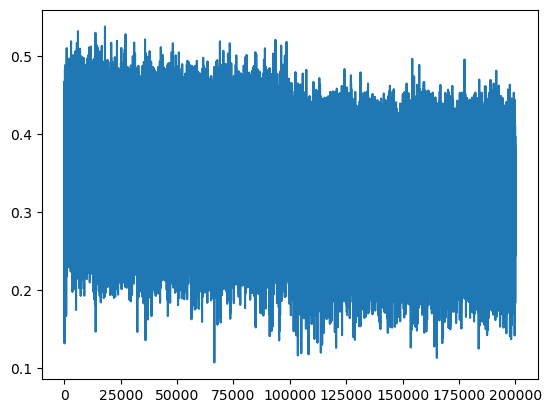

In [321]:
plt.plot(stepi, lossi)

In [322]:
emb = C[X_train]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_train)
loss

tensor(2.0888, grad_fn=<NllLossBackward0>)

In [323]:
emb = C[X_dev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_dev)
loss

tensor(2.1589, grad_fn=<NllLossBackward0>)

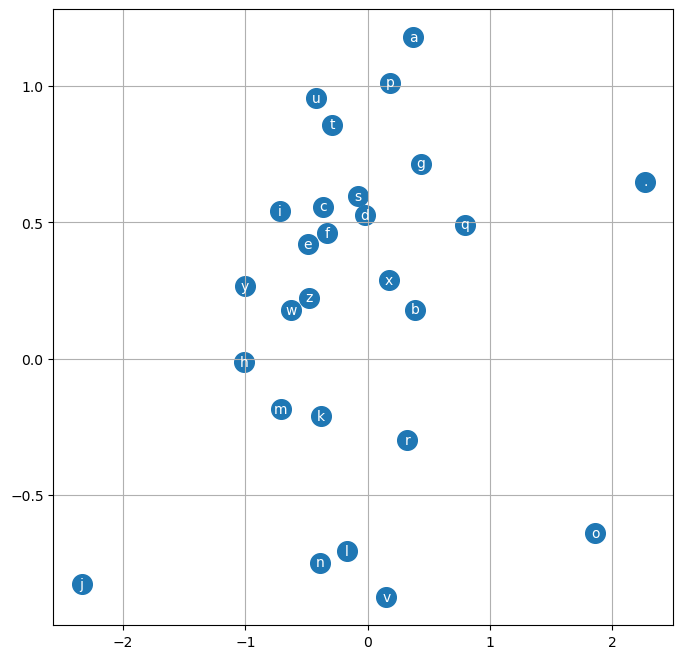

In [324]:
plt.figure(figsize=(8, 8))

plt.scatter(C[:,0].data, C[:,1].data, s=200)

for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), i_to_char[i], ha="center", va="center", color="white")
plt.grid("minor")

In [343]:
g = torch.Generator().manual_seed(2147483647 + 10 )

for _ in range(20):
    out = []
    context = [0]*block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix==0:
            break
        
    print("".join(i_to_char[i] for i in out))
            
        
    

carmahela.
jharlin.
mili.
taty.
halaysa.
jazhneefamerric.
areei.
nellara.
chaiiv.
asleigh.
ham.
poceleen.
thanlee.
alianni.
watthoniearyxi.
jaxe.
pirra.
med.
edo.
abetteley.
